# Neural Network From Scratch
## classification demo

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import numpy as np

from andreiNet.neural_net import NeuralNetwork
from andreiNet.utils import norm_data, one_hot_encode
from andreiNet.metrics import Accuracy
from andreiNet.losses import Loss, CrossEntropy, FocalLoss

$$ Cross Entropy = - \frac{1}{N} \sum_{k} \sum_{i} y_{i, k} \log(p_{i, k}) $$

$$ Focal Loss = - \frac{1}{N} \sum_{k} \sum_{i} \alpha_t (1 - p^t_{i, k})^{\gamma} y_{i, k} \log(p^t_{i, k}) $$
$$ p^t_{i, k} = y_{i, k} \times p_{i, k} $$

In [2]:
y_true = np.array([[1, 0, 0], [0, 1, 0]])
y_pred = np.array([[0.7, 0.2, 0.1], [0.2, 0.2, 0.6]])

ce = CrossEntropy().loss(y_true, y_pred)
print("cross entropy: {}".format(ce))

gamma = 0.0
fl = FocalLoss(gamma=gamma).loss(y_true, y_pred)
print("focal loss (gamma={}): {}".format(gamma, fl))

gamma = 2.0
fl = FocalLoss(gamma=gamma).loss(y_true, y_pred)
print("focal loss (gamma={}): {}".format(gamma, fl))


cross entropy: 0.9830564281864164
focal loss (gamma=0.0): 0.9830564281864164
focal loss (gamma=2.0): 0.5310705044561551


### Example 1: Easy Case, Correctly Classified

In [3]:
y_true = np.array([[1, 0, 0], ])
y_pred = np.array([[0.9, 0.05, 0.05], ])

ce = CrossEntropy().loss(y_true, y_pred)
print("cross entropy: {}".format(ce))

fl = FocalLoss(gamma=gamma).loss(y_true, y_pred)
print("focal loss (gamma={}): {}".format(gamma, fl))

print('ce / fl = {}'.format(ce / fl))

cross entropy: 0.10536051565782628
focal loss (gamma=2.0): 0.0010536051565782623
ce / fl = 100.00000000000006


### Example 2: Hard Case, Correctly Classified

In [4]:
y_true = np.array([[1, 0, 0], ])
y_pred = np.array([[0.4, 0.3, 0.3], ])

ce = CrossEntropy().loss(y_true, y_pred)
print("cross entropy: {}".format(ce))

fl = FocalLoss(gamma=gamma).loss(y_true, y_pred)
print("focal loss (gamma={}): {}".format(gamma, fl))

print('ce / fl = {}'.format(ce / fl))

cross entropy: 0.916290731874155
focal loss (gamma=2.0): 0.3298646634746958
ce / fl = 2.7777777777777777


### Example 3: Incorrectly Classified

In [5]:
y_true = np.array([[1, 0, 0], ])
y_pred = np.array([[0.3, 0.4, 0.4], ])

ce = CrossEntropy().loss(y_true, y_pred)
print("cross entropy: {}".format(ce))

fl = FocalLoss(gamma=gamma).loss(y_true, y_pred)
print("focal loss (gamma={}): {}".format(gamma, fl))

print('ce / fl = {}'.format(ce / fl))

cross entropy: 1.2039728043259361
focal loss (gamma=2.0): 0.5899466741197086
ce / fl = 2.0408163265306127


### Example 4: (very) Incorrectly Classified

In [6]:
y_true = np.array([[1, 0, 0], ])
y_pred = np.array([[0.05, 0.9, 0.05], ])

ce = CrossEntropy().loss(y_true, y_pred)
print("cross entropy: {}".format(ce))

fl = FocalLoss(gamma=gamma).loss(y_true, y_pred)
print("focal loss (gamma={}): {}".format(gamma, fl))

print('ce / fl = {}'.format(ce / fl))

cross entropy: 2.995732273553991
focal loss (gamma=2.0): 2.7036483768824766
ce / fl = 1.10803324099723


In [7]:
# Load Iris Dataset
iris = datasets.load_iris()
X = iris.data  
y = iris.target

# We will also split the dataset into training and testing so we can evaluate the kNN classifier
X_trn, X_test, y_trn, y_test = train_test_split(X, 
                                                y, 
                                                test_size=0.50, 
                                                random_state=0,
                                                stratify=y)

print("X_trn.shape = {}, X_test.shape = {}".format(X_trn.shape, X_test.shape))
X_trn_norm, (trn_mean, trn_std) = norm_data(X_trn)
X_test_norm = (X_test - trn_mean) / trn_std

accuracy = Accuracy().eval

X_trn.shape = (75, 4), X_test.shape = (75, 4)


In [8]:
# Set parameters
activation = 'relu'
batch_size = 50
random_state = 0
lr = 0.001
n_epochs = 10000
weight_init = 'he_norm'
hidden_layers = (20, 20, )


In [9]:
loss = CrossEntropy() #'cross_entropy'


# Train model

# Initialize model
start_time = time.time()
nn = NeuralNetwork(hidden=hidden_layers, 
                   init_weights=weight_init,
                   loss=loss,
                   activation=activation,
                   shuffle=True,
                   random_state=random_state,
                   metrics=['accuracy'],
                   verbose=False
                   )

nn.train(X_trn_norm, y_trn, 
         n_epochs=n_epochs,
         batch_size=batch_size, 
         early_stop=None, # ('accuracy', 500),
         lr=lr, 
         val_data=(X_test_norm, y_test),
         save_best=True)

# Run Inference
y_pred_trn = nn.predict(X_trn_norm).argmax(axis=1)
y_pred_test = nn.predict(X_test_norm).argmax(axis=1)

delta_1 = time.time() - start_time
print("--- %s seconds ---" % (delta_1))
print('trn acc', accuracy(y_pred_trn, y_trn))
print('test acc', accuracy(y_pred_test, y_test))

epoch 10000: final trn loss = 0.04726542854692928 trn metrics {'accuracy': 1.0, cross_entropy: 0.04726542854692928}
val metrics {'accuracy': 0.92, cross_entropy: 0.13995125728964597}
setting best model from epoch 8543
--- 8.603633642196655 seconds ---
trn acc 0.9866666666666667
test acc 0.92


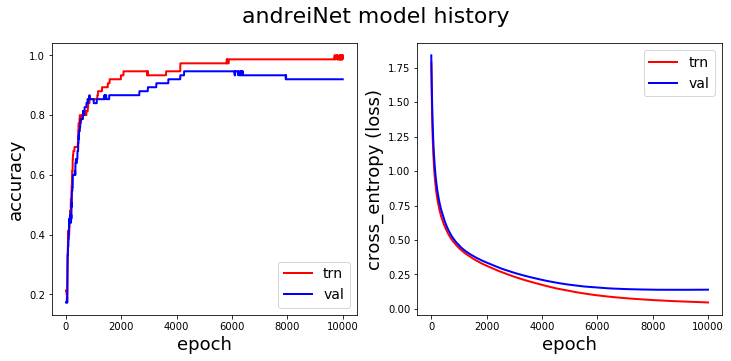

In [10]:
# Plot neural network history
fig_size = (12, 5)
x_axis = np.arange(len(nn.trn_metric_hist[loss]))
metrics = nn.trn_metric_hist.keys()
fig, axs = plt.subplots(1, 2, figsize=fig_size)

for i, metric in enumerate(metrics):
    axs[i].plot(x_axis, nn.trn_metric_hist[metric], c='r', linewidth=2, label='trn')
    axs[i].plot(x_axis, nn.val_metric_hist[metric], c='b', linewidth=2, label='val')
    axs[i].set_xlabel('epoch', fontsize=18)
    axs[i].set_ylabel(metric, fontsize=18)
    if metric == loss:
        axs[i].set_ylabel(str(metric)+' (loss)', 
                          fontsize=18)
    axs[i].legend(prop={'size': 14})
    
plt.suptitle('andreiNet model history', fontsize=22)
plt.show()

In [11]:
loss = FocalLoss(gamma=1.0) #'cross_entropy'


# Train model

# Initialize model
del nn
start_time = time.time()
nn = NeuralNetwork(hidden=hidden_layers, 
                   init_weights=weight_init,
                   loss=loss,
                   activation=activation,
                   shuffle=True,
                   random_state=random_state,
                   metrics=['accuracy'],
                   verbose=False
                   )

nn.train(X_trn_norm, y_trn, 
         n_epochs=n_epochs,
         batch_size=batch_size, 
         early_stop=None, # ('accuracy', 500),
         lr=10*lr, 
         val_data=(X_test_norm, y_test),
         save_best=True)

# Run Inference
y_pred_trn = nn.predict(X_trn_norm).argmax(axis=1)
y_pred_test = nn.predict(X_test_norm).argmax(axis=1)

delta_1 = time.time() - start_time
print("--- %s seconds ---" % (delta_1))
print('trn acc', accuracy(y_pred_trn, y_trn))
print('test acc', accuracy(y_pred_test, y_test))

epoch 10000: final trn loss = 0.02745895795008811 trn metrics {'accuracy': 1.0, focal_loss: 0.02745895795008811}
val metrics {'accuracy': 0.9333333333333333, focal_loss: 0.0857989657354737}
setting best model from epoch 8532
--- 9.437421798706055 seconds ---
trn acc 1.0
test acc 0.9333333333333333


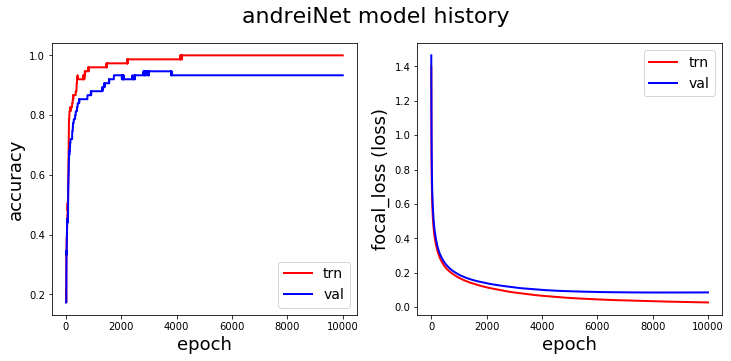

In [12]:
# Plot neural network history
fig_size = (12, 5)
x_axis = np.arange(len(nn.trn_metric_hist[loss]))
metrics = nn.trn_metric_hist.keys()
fig, axs = plt.subplots(1, 2, figsize=fig_size)

for i, metric in enumerate(metrics):
    axs[i].plot(x_axis, nn.trn_metric_hist[metric], c='r', linewidth=2, label='trn')
    axs[i].plot(x_axis, nn.val_metric_hist[metric], c='b', linewidth=2, label='val')
    axs[i].set_xlabel('epoch', fontsize=18)
    axs[i].set_ylabel(metric, fontsize=18)
    if metric == loss:
        axs[i].set_ylabel(str(metric)+' (loss)', 
                          fontsize=18)
    axs[i].legend(prop={'size': 14})
    
plt.suptitle('andreiNet model history', fontsize=22)
plt.show()